# Compare CMIP6 and ERA5 between 2015 and 2024

In [116]:
import time

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from shapely.geometry import Polygon
import difflib
import glob
import os
from pathlib import Path
import xarray as xr
import re

from netCDF4 import Dataset

Read in ERA5 data

In [132]:
era5_data_xr = xr.open_dataset('/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/monthly_data/724bab97773bb7ba4e1635356ad0d12.nc')

era5_data_xr_2015_2024 = era5_data_xr.sel(date = slice('20140101', '20250101'))


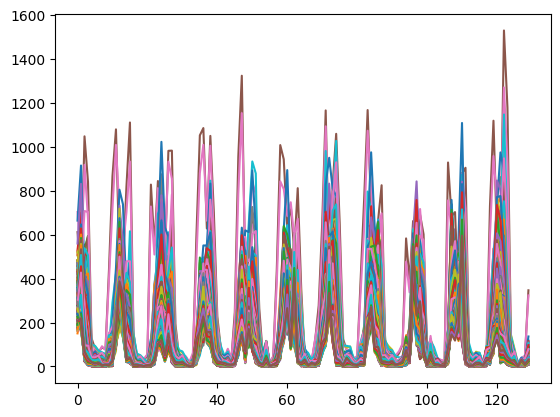

In [133]:
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month = 0
for i in range(len(era5_data_xr_2015_2024['latitude'][:])):
    for j in range(len(era5_data_xr_2015_2024['longitude'][:])):
        pr_data_time_series_grid = era5_data_xr_2015_2024['tp'][:, i, j]
        pr_data_time_series_grid *= 1000 * days_in_month[month] # to get to mm
        plt.plot(pr_data_time_series_grid)
        month = (month + 1) % 12

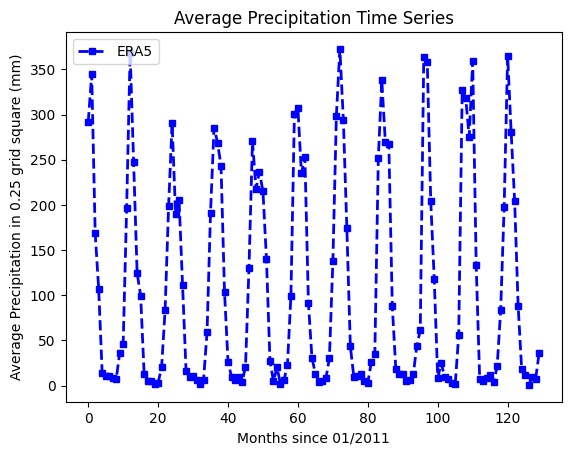

In [134]:
pr_data_time_series_avg_ERA5 = era5_data_xr_2015_2024['tp'].mean(dim=['latitude', 'longitude'])

# Plot the averaged precipitation time series with distinct styles
plt.plot(pr_data_time_series_avg_ERA5 * 1000 * 30, color="blue", linewidth=2, linestyle='--', marker='s', markersize=4, label='ERA5')

plt.xlabel('Months since 01/2011')
plt.ylabel('Average Precipitation in 0.25 grid square (mm)')
plt.title('Average Precipitation Time Series')
plt.legend()
plt.show()

Now load the CMIP6 data - ssp 2.45

Per month

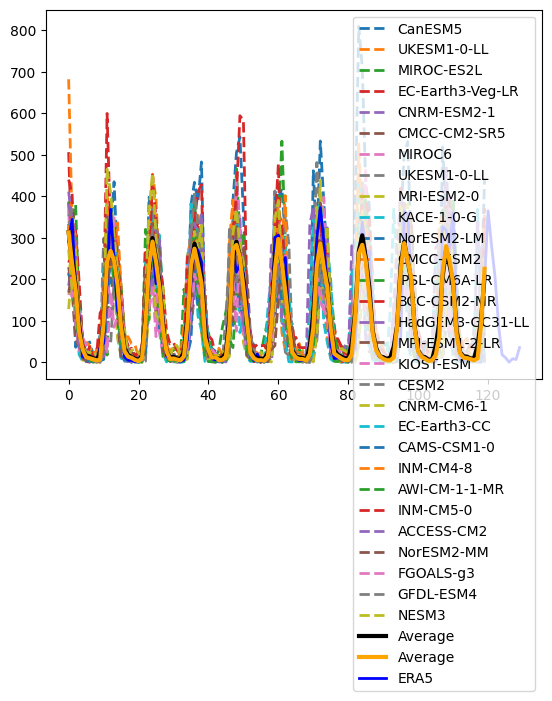

In [169]:
base_dir = "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/ssp2_4_5"
nc_file_directory = os.path.join(base_dir, 'nc_files')
# NB these are daily 
scenario = 'ssp2_4_5'
multiplier = 86400
years = range(2015, 2025)
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] * len(years)

cumulative_sum_by_models = {}
for file in glob.glob(os.path.join(nc_file_directory, "*.nc")):
    model = re.search(r'pr_day_(.*?)_' + scenario.replace('_', ''), file).group(1)
    if model == 'IITM-ESM':
        continue # have seen from plots that this is a major outlier
    data_per_model  = xr.open_dataset(file)
    data_per_model_2015_2024 = data_per_model.sel(time = slice('2015-01-01', '2025-01-01'))
    pr_data = data_per_model_2015_2024['pr'][:] * multiplier  # in kg m-2 s-1 = mm s-1 x 86400 to get to day
    pr_data_avg_area_model = pr_data.mean(dim=['lat', 'lon'])
    cumulative_sum_window_for_model = []
    begin_day = 0
    for month_idx, month_length in enumerate(month_lengths):
        days_for_grid = pr_data_avg_area_model[begin_day:begin_day + month_length]
        cumulative_sums = sum(days_for_grid)
        if isinstance(cumulative_sums, int):
            cumulative_sum_window_for_model.append(cumulative_sums)
        else:
            cumulative_sum_window_for_model.append(cumulative_sums.values)
        begin_day += month_length
        cumulative_sum_by_models[model] = cumulative_sum_window_for_model
    plt.plot(cumulative_sum_window_for_model, linewidth=2, linestyle='--', label = model)

cumulative_sums_df = pd.DataFrame(cumulative_sum_by_models)
mean_cumulative_sum = cumulative_sums_df.mean(axis=1)
median_cumulative_sum = cumulative_sums_df.median(axis=1)
plt.plot(mean_cumulative_sum, color='black', linewidth=3, label='Average', zorder=10)
plt.plot(median_cumulative_sum, color='orange', linewidth=3, label='Average', zorder=10)

plt.plot(pr_data_time_series_avg_ERA5 * 30 * 1000, color="blue", linewidth=2, linestyle='-',markersize=4, label='ERA5')

plt.legend()


Text(0, 0.5, 'Average monthly precipitation across Malawi (mm)')

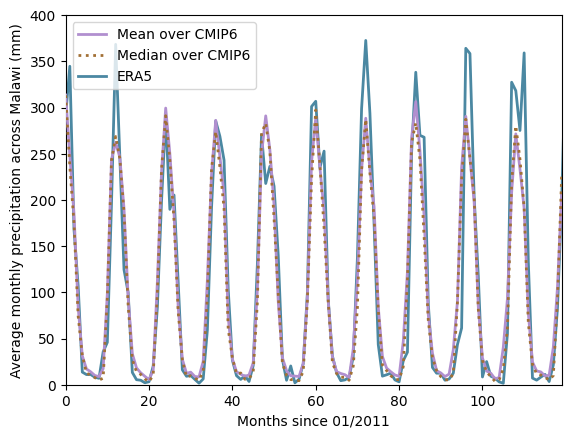

In [173]:
plt.plot(mean_cumulative_sum, color='#B18FCF', linewidth=2, label='Mean over CMIP6', zorder=10)
plt.plot(median_cumulative_sum, color='#A27035', linewidth=2, linestyle = ':',label='Median over CMIP6', zorder=10)

plt.plot(pr_data_time_series_avg_ERA5 * 30 * 1000, color="#4B88A2", linewidth=2, linestyle='-',markersize=4, label='ERA5')

plt.legend()
plt.ylim(0,400)
plt.xlim(0, (12*10) -1 )
plt.xlabel("Months since 01/2011")
plt.ylabel("Average monthly precipitation across Malawi (mm)")

Per day

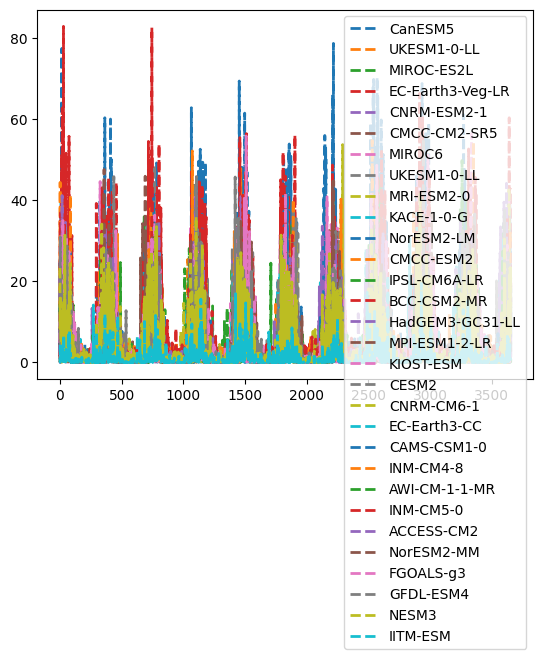

In [108]:
base_dir = "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/ssp2_4_5"
nc_file_directory = os.path.join(base_dir, 'nc_files')
# NB these are daily 
scenario = 'ssp2_4_5'
multiplier = 86400
years = range(2015, 2025)
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] * len(years)

for file in glob.glob(os.path.join(nc_file_directory, "*.nc")):
    model = re.search(r'pr_day_(.*?)_' + scenario.replace('_', ''), file).group(1)
    data_per_model  = xr.open_dataset(file)
    data_per_model_2015_2024 = data_per_model.sel(time = slice('2015-01-01', '2025-01-01'))
    pr_data = data_per_model_2015_2024['pr'][:] * multiplier  # in kg m-2 s-1 = mm s-1 x 86400 to get to day
    pr_data_avg_area_model = pr_data.mean(dim=['lat', 'lon'])
    plt.plot(pr_data_avg_area_model, linewidth=2, linestyle='--', label = model)
    plt.legend()

Monthly mean per day

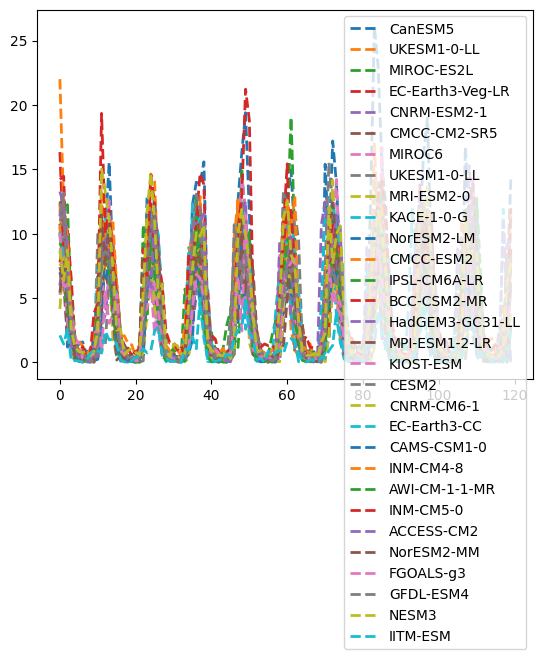

In [109]:
base_dir = "/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/ssp2_4_5"
nc_file_directory = os.path.join(base_dir, 'nc_files')
# NB these are daily 
scenario = 'ssp2_4_5'
multiplier = 86400
years = range(2015, 2025)
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] * len(years)

for file in glob.glob(os.path.join(nc_file_directory, "*.nc")):
    model = re.search(r'pr_day_(.*?)_' + scenario.replace('_', ''), file).group(1)
    data_per_model  = xr.open_dataset(file)
    data_per_model_2015_2024 = data_per_model.sel(time = slice('2015-01-01', '2025-01-01'))
    pr_data = data_per_model_2015_2024['pr'][:] * multiplier  # in kg m-2 s-1 = mm s-1 x 86400 to get to day
    pr_data_avg_area_model = pr_data.mean(dim=['lat', 'lon'])
    cumulative_sum_window_for_model = []
    begin_day = 0
    for month_idx, month_length in enumerate(month_lengths):
        days_for_grid = pr_data_avg_area_model[begin_day:begin_day + month_length]
        cumulative_sums = sum(days_for_grid)/month_length
        cumulative_sum_window_for_model.append(cumulative_sums)
        begin_day += month_length
    plt.plot(cumulative_sum_window_for_model, linewidth=2, linestyle='--', label = model)
    plt.legend()